In [2]:
import tensorflow as tf
print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.20.0


In [13]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import joblib
import numpy as np

# Custom layer to wrap tf.reduce_mean
class ReduceMeanLayer(tf.keras.layers.Layer):
    def call(self, inputs):
        return tf.reduce_mean(inputs, axis=1)
    
# Load the saved model with the custom layer
model = tf.keras.models.load_model('NNmodel.h5')

# Recompile the model with the desired optimizer
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Load the new data
toi_data = pd.read_csv('TOI_2025.08.02_05.03.17_final.csv')

# Define the feature columns
features = ['pl_orbper', 'pl_trandurh', 'pl_trandep', 'pl_rade', 'pl_eqt', 'pl_insol', 'st_teff', 'st_logg', 'st_rad', 'fe_h']
data_pred = toi_data[features]

# Drop rows with missing data in the selected features
data_pred_cleaned = data_pred.dropna()

# Update the original DataFrame to reflect the dropped rows
toi_data_cleaned = toi_data.loc[data_pred_cleaned.index]

# Load the saved scaler
scaler = joblib.load("scaler_transformer.pkl")

# Apply the same scaling
X_scaled = scaler.transform(data_pred_cleaned.values)

# Reshape for model input
X_new_scaled = np.expand_dims(X_scaled, axis=-1)  # Match training shape

# Make predictions
y_pred_prob = model.predict(X_new_scaled)
y_pred = (y_pred_prob > 0.5).astype("int32")

# Reset index of cleaned DataFrame and add predictions
toi_data_cleaned = toi_data_cleaned.reset_index(drop=True)
toi_data_cleaned['Prediction'] = y_pred

# Save the updated dataframe to a new CSV file
toi_data_cleaned.to_csv('TOI_2025.08.02_05.03.17_final_predicted_TF.csv', index=False)

print("Predictions added and saved to TOI_2025.08.02_05.03.17_final_predicted.csv")

TypeError: Error when deserializing class 'MultiHeadAttention' using config={'name': 'multi_head_attention', 'trainable': True, 'dtype': 'float32', 'num_heads': 2, 'key_dim': 32, 'value_dim': 32, 'dropout': 0.1, 'use_bias': True, 'output_shape': None, 'attention_axes': [1], 'kernel_initializer': {'class_name': 'GlorotUniform', 'config': {'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None, 'query_shape': [None, 10, 1], 'key_shape': [None, 10, 1], 'value_shape': [None, 10, 1]}.

Exception encountered: Unrecognized keyword arguments passed to MultiHeadAttention: {'query_shape': [None, 10, 1], 'key_shape': [None, 10, 1], 'value_shape': [None, 10, 1]}

In [4]:
# Calculate TP, TN, FP, FN
tp = len(toi_data_cleaned[(toi_data_cleaned['Prediction'] == 1) & (toi_data_cleaned['tfopwg_disp'].isin(['CP', 'KP']))])
tn = len(toi_data_cleaned[(toi_data_cleaned['Prediction'] == 0) & (toi_data_cleaned['tfopwg_disp'].isin(['FP', 'FA']))])
fp = len(toi_data_cleaned[(toi_data_cleaned['Prediction'] == 1) & (toi_data_cleaned['tfopwg_disp'].isin(['FP', 'FA']))])
fn = len(toi_data_cleaned[(toi_data_cleaned['Prediction'] == 0) & (toi_data_cleaned['tfopwg_disp'].isin(['CP', 'KP']))])

# Print TP, TN, FP, FN
print(f"TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")

TP: 914, TN: 407, FP: 283, FN: 213


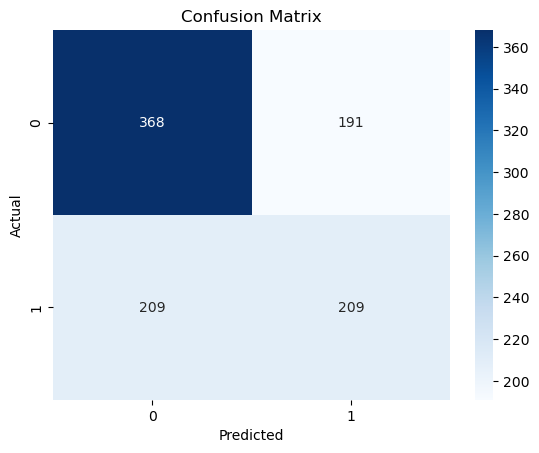

Recall: 0.5
Precision: 0.5225
Accuracy: 0.5905834186284544
F1 Score: 0.511002444987775


In [5]:
# To be revised
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Exclude any item in toi_data_cleaned with "tfopwg_disp" that does not equal to "CP" or "FP"
toi_data_cleaned = toi_data_cleaned[toi_data_cleaned['tfopwg_disp'].isin(['CP', 'FP'])]

# Draw a confusion matrix
conf_matrix = confusion_matrix(toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'FP': 0}), toi_data_cleaned['Prediction'])
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('Confusion Matrix.pdf')
plt.show()

# Calculate evaluation metrics
recall = recall_score(toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'FP': 0}), toi_data_cleaned['Prediction'])
precision = precision_score(toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'FP': 0}), toi_data_cleaned['Prediction'])
accuracy = accuracy_score(toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'FP': 0}), toi_data_cleaned['Prediction'])
f1 = f1_score(toi_data_cleaned['tfopwg_disp'].map({'CP': 1, 'FP': 0}), toi_data_cleaned['Prediction'])

# Print evaluation metrics
print(f"Recall: {recall}")
print(f"Precision: {precision}")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")